# This notebook will plot the distribution of V1 cell responses to natural images. The data is 2P calcium responses in the mouse brain, from the Allen Brain Observatory. 


# First load the data for a sample mouse

In [45]:
#load data (V1, natural image responses) for a sample mouse
import os
import platform
import pandas as pd
import numpy as np
import cPickle as cpickle

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info


#sets the drive path of hard-disk containing observatory data, based on current OS
if platform.system()=='Windows':
    drive_path = 'g:/'
else:
    drive_path = '/Volumes/Brain2016 3/'

manifest_path = os.path.join(drive_path, 'BrainObservatory/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
print(cre_lines)

# find all experiment containers that are from V1 and have natural gratings, and choose 1
rbp4_ecs = boc.get_experiment_containers(targeted_structures=['VISp'],cre_lines=['Rbp4-Cre'])

container_id = rbp4_ecs[1]['id']
print len(rbp4_ecs)

exp = boc.get_ophys_experiments(experiment_container_ids=[container_id], 
                                stimuli=[stim_info.NATURAL_SCENES])[0]


print('Experiment container info:')
print exp

# get the dff traces, and the stimulus, and pull out the raw dff traces in case we need these later
data_set = boc.get_ophys_experiment_data(exp['id'])
specimens=data_set.get_cell_specimen_ids()
timestamps, traces = data_set.get_dff_traces()

all cre lines:

[u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Nr5a1-Cre', u'Rbp4-Cre', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']
4
Experiment container info:
{'session_type': u'three_session_B', 'age_days': 86.0, 'imaging_depth': 375, 'experiment_container_id': 511510758, 'targeted_structure': u'VISp', 'cre_line': u'Rbp4-Cre', 'id': 509600709}


In [46]:
# stimulus info
# there are 118 (0-117) natural images. images were luminance matched, contrast-normalized, and resized.
# each image was presented for 250 ms, with no inter-image gray period
# each image was presented 50 times, in random order
# there was a blank sweep roughly once every 100 images. this is coded as a -1
# these 118*50=5900+59 images were split across three sessions

# pull out the stim info
stim_table = data_set.get_stimulus_table('natural_scenes') #table with image index and start and end times of each trial
num_trials = np.shape(stim_table)[0]
image_id = stim_table.frame; # this is the index of the image
num_images = 119;

# to acces the response during a particular trial, you would call
cell_loc=0
trial_loc=0
sample_trace = traces[cell_loc,stim_table.start[trial_loc]-28:stim_table.end[trial_loc]+28] # the added second before and
                                                                        # after the stimulus are to match
                                                                        # the allenSDK's definition of sweep response

    
mean_responses=[]
for i in range(num_trials):
    mean_responses.append(np.mean(traces[:,stim_table.start[i]-28:stim_table.end[i]+28],axis=1))


mean_responses = np.squeeze(np.array(mean_responses))

In [ ]:
# the mean trial responses are already pre-calculated in allenSDK, so we'll just use those instead of using the code above
# to extract single traces and calculating a trial average. But remember that the traces extracted from the NWB (as above) will 
# have a global (experiment-wide) dff whereas the traces calculated from the SDK will have a local dff. See sweep-response-test
# notebook. This shouldn't  produce huge differences in the sparicity stats, so we'll just use the allenSDK values.


# For each trial, the ΔF/F for each cell was calculated using the mean fluorescence of the preceding 1 second
# as the baseline Fo.

# The mean response to each image presentation was defined as the mean change in dff during the 0.5 second period 
# following the start of the image presentation compared to the 1 second preceding the image presentation.

In [47]:
# load pre-calculated trials and trial statisics from the allenSDK module
from allensdk.brain_observatory.natural_scenes import NaturalScenes
# allensdk.brain_observatory.natural_scenes.NaturalScenes(data_set, **kwargs)[source]
ns = NaturalScenes(data_set)
print("done analyzing natural scenes")

done analyzing natural scenes


In [ ]:
# save the data
results_file='sample_data.pkl'
f=open(results_file,"wb")
cpickle.dump(data_set, f,protocol=cpickle.HIGHEST_PROTOCOL)
cpickle.dump(ns, f,protocol=cpickle.HIGHEST_PROTOCOL)
cpickle.dump(stim_table, f,protocol=cpickle.HIGHEST_PROTOCOL)
f.close()

# Or, skip to here and just load the data saved after running above


In [44]:
import os
import platform
import pandas as pd
import numpy as np
import cPickle as cpickle

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

# load the data
results_file='sample_data.pkl'
print 'loading saved file'
print results_file
f = open(results_file, "rb")
data_set = cpickle.load(f)
ns = cpickle.load(f)
stim_table = cpickle.load(f)
f.close()
#and calculate other quick things we'll need

num_trials = np.shape(stim_table)[0]
image_id = stim_table.frame; # this is the index of the image
num_images = 119;

# to acces the response during a particular trial, you would call
cell_loc=0
trial_loc=0

loading saved file
sample_data.pkl


IOError: [Errno 2] No such file or directory: 'sample_data.pkl'

In [4]:
# to get the sweep response
trial_responses = ns.sweep_response
print 'trial_responses is a dataframe of size' +np.str(np.shape(trial_responses))

# to get the sweep response for a particular cell and trial
sample_response = trial_responses[str(cell_loc)].iloc[trial_loc] 
print ('sample response is a vector of size ' +np.str(np.shape(sample_response))+' as it includes 1 sec before/after stim')

# to get the mean trial response 
trial_means = ns.mean_sweep_response
print ('trial_means is a dataframe of size ' +np.str(np.shape(trial_means)))

# to get the mean sweep response for a particular cell and trial
sample_mean = trial_means[str(cell_loc)].iloc[trial_loc] 
print ('sample_mean is a vector of size ' +np.str(np.shape(sample_mean)))


# We can also get the mean triaal responses averaged over all 50 presentation of the same image using ns.responses
# The response property of the stimulus-specific analysis objects is 3-D array organized with the following dimensions:
# 0: num. number of natural scene frames (118+blank)
# 1: num. cells + 1 (running speed)
# 2: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

# to get mean trial response averaged over all 50 presentations of an image
mean_over_image = ns.response[:,cell_loc,0] #outputs a 119x1 vector of mean resonse over each image

print '\nyou can get the mean response averaged over all 50 repeats of an image using the ns.response module'

#The peak property of the analysis object is a Pandas DataFrame of computed response metrics.
# For natural scences this includes:

# or you can just print the values for a particular cell
specimen_id = specimens[0]
specimen_ids = data_set.get_cell_specimen_ids()
cell_loc = np.argwhere(specimen_ids==specimen_id)[0][0]


print '\nyou can also get additional parameters using the ns.peak module'
print ns.peak.loc[cell_loc].head()

# we weon't use these here. I'm just posting the code here for reference.

NameError: name 'ns' is not defined

# Plot the response distribution one cell to all images

kurtosis of distribution of responses, averaged over all unique images is 2.22411568778


NameError: name 'trial_means' is not defined

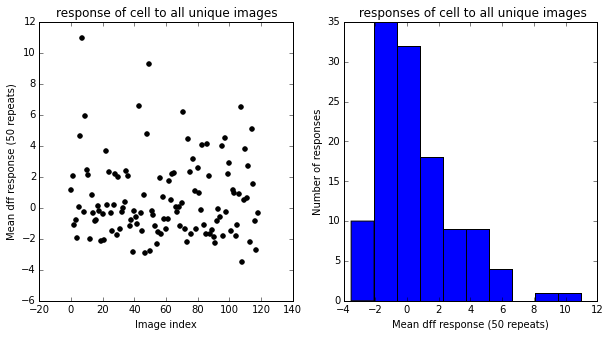

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

cell_loc=0

######################### plot the mean response of one cell to all unique images (mean over 50 repeats of each image)
mean_cell = np.squeeze(ns.response[:,cell_loc,0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,119,1), mean_cell, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('Mean dff response (50 repeats)')
axs[0].set_title('response of cell to all unique images')

axs[1].hist(mean_cell)
axs[1].set_ylabel('Number of responses')
axs[1].set_xlabel('Mean dff response (50 repeats)')
axs[1].set_title(' responses of cell to all unique images')
plt.tick_params(axis='y', which='both', top='off')

#measure the kurtosis of the histogram
k1=stats.kurtosis(mean_cell, axis=0, fisher=True, bias=True)
print 'kurtosis of distribution of responses, averaged over all unique images is '+ np.str(k1)

####################### now plot the response of one cell to all images

mean_cell = trial_means[str(cell_loc)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,num_trials,1), mean_cell, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('dff response')
axs[0].set_title('response of cell to all images')

axs[1].hist(mean_cell)
axs[1].set_ylabel('Number of responses')
axs[1].set_xlabel('dff response ')
axs[1].set_title('responses of cell to all images')
plt.tick_params(axis='y', which='both', top='off')

#measure the kurtosis of the histogram
k1=stats.kurtosis(mean_cell, axis=0, fisher=True, bias=True)
print 'kurtosis of distribution of responses to all images is '+ np.str(k1)

####################### now see if you can get back the top plot (mean over each image), from the trial responses
#### the answer is yes so I'm going to comment this section out
#mean_over_image=[]
#for i in range(num_images):
#    temp_ind=np.flatnonzero(image_id==i-1)
#    mean_over_image.append(np.mean(trial_means[str(cell_loc)].iloc[temp_ind]))

#print np.shape(mean_over_image)

#fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#axs = axs.ravel()

#axs[0].scatter(np.arange(0,num_images,1), mean_over_image, color='k')
#axs[0].set_xlabel('Image index')
#axs[0].set_ylabel('Mean dff response (50 repeats)')
#axs[0].set_title('response of cell to all unique images')

#axs[1].hist(mean_over_image)
#axs[1].set_ylabel('Number of responses')
#axs[1].set_xlabel('Mean dff response (50 repeats)')
#axs[1].set_title(' responses of cell to all unique images')
#plt.tick_params(axis='y', which='both', top='off')

# Now define the sparsity of each cell's respones (lifetime sparseness) using two metrics:
Both metrics will be calculated based on the average (over 50 repeats) response to each unique image.
# 1) kurtosis of distribution of average response over 50 repeats. Higher values       indicate higher sparsity

# 2) 1- (mean response over all/mean square response over all) <-- from literature

# We'll compare these metrics on simulated and real data.


In [42]:
from scipy import stats

# define the indices 
def get_indk(data):
    return stats.kurtosis(data, axis=0, fisher=True, bias=True)

def get_indv(data):
    num_images = np.shape(data)[0]
    mean_resp_cell = np.mean(np.abs(data))
    numerator = mean_resp_cell**2
    denominator = (1/float(num_images))*np.sum(np.array(data)**2)
    sprs_indv = 1-(numerator/float(denominator))
    return sprs_indv

# test these indices on a distribution with known kurtosis (normal distribution has kurtosis of 0)
data = 15+np.random.normal(0,1,10000) #data form normal distribution

sprs_indk = get_indk(data)
sprs_indv = get_indv(data)
                 
print 'the sparsity index (k) for a normal distribution should be 0, our code gives: ' +np.str(sprs_indk)
print 'the sparsity index (v) for a normal distribution should be 0, our code gives: ' +np.str(sprs_indv)


the sparsity index (k) for a normal distribution should be 0, our code gives: -0.000246592874123
the sparsity index (v) for a normal distribution should be 0, our code gives: 0.00437227648632


# Now get the sparsity metric for all cells in this mouse and plot distribution

In [43]:
num_cells = np.shape(ns.response[:,:,0])[1]-1

sprs_indk = []
sprs_indv = []
for i in range(num_cells):
    data = np.squeeze(ns.response[:,i,0])
    sprs_indk.append(get_indk(data))
    sprs_indv.append(get_indv(data))

    
# now plot
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs = axs.ravel()

axs[0].hist(sprs_indk)
axs[0].set_ylabel('Number of neurons')
axs[0].set_xlabel('Sparsity Index (kurtosis)')
plt.tick_params(axis='y', which='both', top='off')

axs[1].hist(sprs_indv)
axs[1].set_xlabel('Sparsity Index (Cv)')
plt.tick_params(axis='y', which='both', top='off')

axs[2].hist(sprs_indf)
axs[2].set_xlabel('Sparsity Index (fixed threshold)')
plt.tick_params(axis='y', which='both', top='off')


NameError: name 'ns' is not defined

# We'll move forward with the first two metrics.
Looks like the kurtosis-based and variable threshold indices produce more or less similar results, but the last index based on fixed threshold doesn't. It also reports that the majority of cells are highly sparse, which is in disagreement with the other two metrics.

In [ ]:
# plot the first two metrics against each other to see their correlation

fig, axs = plt.subplots()
plt.scatter(sprs_indk,sprs_indv)
plt.xlabel('Sparsity Index (kurtosis)')
plt.ylabel('Sparsity Index (variable threshold)')
plt.title('Comparison of first two metrics')

# Now get the mean sparsity metric averaged over each mouse, for all transgenic mice in V1, and plot distribution

In [7]:
['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Nr5a1-Cre', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre']
from allensdk.brain_observatory.natural_scenes import NaturalScenes

sparsity_dict_cre = {}
for cre_line in cre_lines:
    print cre_line
    container_list_filt = pd.DataFrame(boc.get_experiment_containers(targeted_structures=['VISp'],cre_lines=[cre_line]))

    sparsity_dict_cre_container = {}
    for ind in np.arange(len(container_list_filt)):
        container_id = container_list_filt['id'].values[ind]  # This goes through the different mice

        print container_id
        
        exp = boc.get_ophys_experiments(experiment_container_ids=[container_id], 
                                stimuli=[stim_info.NATURAL_SCENES])[0]
        data_set = boc.get_ophys_experiment_data(exp['id'])
        ns = NaturalScenes(data_set)
        num_cells = np.shape(ns.response[:,:,0])[1]-1
        
        sprs_indk = []
        sprs_indf = []
        sprs_indv = []
        for i in range(num_cells):
            mean_over_image = np.squeeze(ns.response[:,i,0])
            sprs_indk.append(get_indk(mean_over_image))
            sprs_indv.append(get_indv(mean_over_image))

        sparsity_dict_cre_container[container_id] = np.mean(sprs_indv)
    sparsity_dict_cre[cre_line] = sparsity_dict_cre_container



Cux2-CreERT2
511510736
511510884
511510667
511510855
511510650
511509529
511510927
511510670
511507650
511510718
511510779
511510699
511510736
511510884
511510667
511510855
511510650
524691282
511509529
511510927
511510670
527550471
530243910
511507650
511510718
528959519
511510779
511510699
511510736
511510884
511510667
511510855
511510650
524691282
511509529
511510927
511510670
527550471
530243910
511507650
511510718
528959519
511510779
511510699
Emx1-IRES-Cre
527683915
528544341
530078243
540168835
526787625
517328083
530738229
540650206
536323956
529676887
528694719
530688634
528521086
527676429
527683915
528544341
530078243
540168835
526787625
517328083
530738229
540650206
536323956
529676887
528694719
530688634
528521086
527676429
Nr5a1-Cre
532233174
528792730
539291370
528799602
531100608
538803515
529763300
532233174
528792730
539291370
528799602
531100608
538803515
529763300
Rbp4-Cre
511510896
511510758
511510635
511510974
Rbp4-Cre_KL100
511510896
511510758
511510635
529770662

In [8]:
# save the data
results_file='nat_scenes_v1_sparsity.pkl'
f=open(results_file,"wb")
cpickle.dump(sparsity_dict_cre, f,protocol=cpickle.HIGHEST_PROTOCOL)
f.close()

In [10]:
sparsity_dict_cre

{u'Cux2-CreERT2': {511507650: 0.18879441972867581,
  511509529: 0.17220893991399377,
  511510650: 0.16729288034232098,
  511510667: 0.17339939749484704,
  511510670: 0.13930629970108852,
  511510699: 0.13166060888023032,
  511510718: 0.14865216177105287,
  511510736: 0.15770049060086469,
  511510779: 0.14756069740915759,
  511510855: 0.12746066327765679,
  511510884: 0.11268605283840158,
  511510927: 0.12843519786769336,
  524691282: 0.1020840336134454,
  527550471: 0.097660959120490318,
  528959519: 0.12308823529411766,
  530243910: 0.10808275273157764},
 u'Emx1-IRES-Cre': {517328083: 0.13194630872483223,
  526787625: 0.066922347886523056,
  527676429: 0.13491912371885173,
  527683915: 0.081274888333711867,
  528521086: 0.13124891335844685,
  528544341: 0.053646328096455996,
  528694719: 0.11619047619047621,
  529676887: 0.13228558264036688,
  530078243: 0.12885257806826439,
  530688634: 0.07938713416401047,
  530738229: 0.13642038633635276,
  536323956: 0.12490396158463388,
  5401688